# Preprocessing and clustering 3k PBMCs

In [2]:
import numpy as np
import pandas as pd 
import scanpy as sc

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
sc.settings.verbosity = 3                                             # verbosity: errors(0), warnings(1), info(2), hints(3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

/home/mesqueda/miniconda3/envs/scanpy/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.9.6 anndata==0.10.3 umap==0.5.5 numpy==1.26.2 scipy==1.11.4 pandas==2.1.3 scikit-learn==1.3.2 statsmodels==0.14.0 igraph==0.11.3 pynndescent==0.5.11


In [4]:
results_file = 'write/pbmc3k.h5ad'                                    # the file that will store the analysis results

Read in count matrix into an AnnData object, which holds slots for annotations and different representations of the data. Also comes with HDF5-based file format `.h5ad`.

In [5]:
adata = sc.read_10x_mtx('data/filtered_gene_bc_matrices/hg19/',       # dir/ containing the .mtx file 
                       var_names='gene_symbols',                      # use gene symbols for the variable names (variables-axis index)
                       cache=True)                                    # write a cache files for faster subsequent reading

... reading from cache file cache/data-filtered_gene_bc_matrices-hg19-matrix.h5ad


In [6]:
adata.var_names_make_unique()                                         # unecessary if using `var_vames='gene_ids'`

In [7]:
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

## Preprocessing 

Show the genes that yield the highest fraction of counts in each single cell, across all cells.

normalizing counts per cell
    finished (0:00:00)


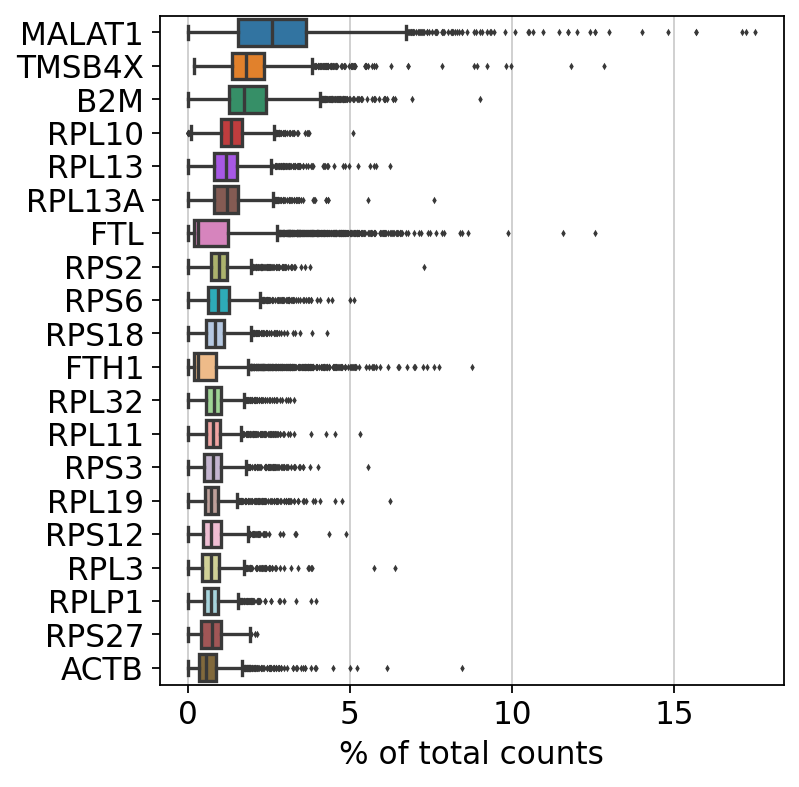

In [8]:
sc.pl.highest_expr_genes(adata, n_top=20,)

Basic filtering:

In [9]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 19024 genes that are detected in less than 3 cells


Use `pp.calculate_qc_matrics`, to compute metrics efficiently.

In [10]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')                 # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata,qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

Violin plot of some of the computed quality measures

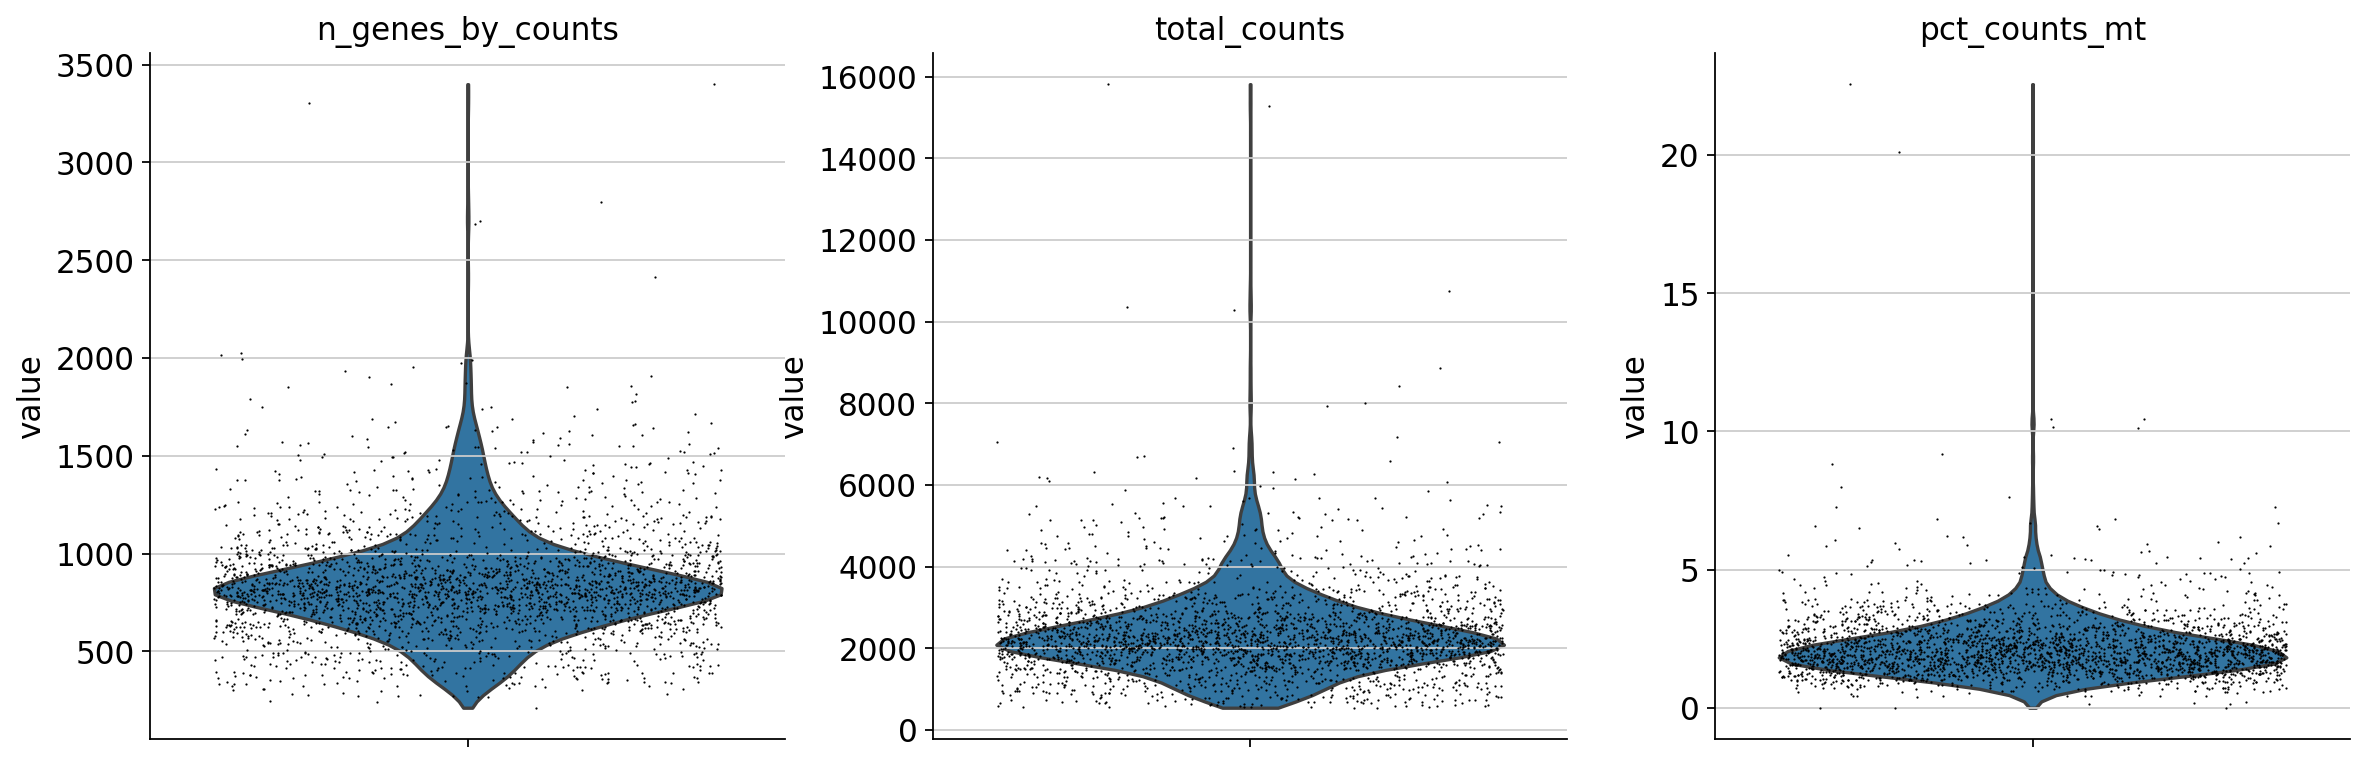

In [11]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
            jitter=0.4, multi_panel=True)

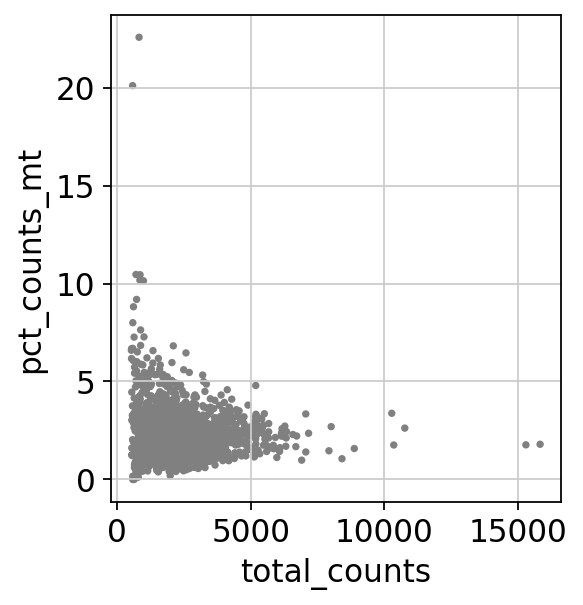

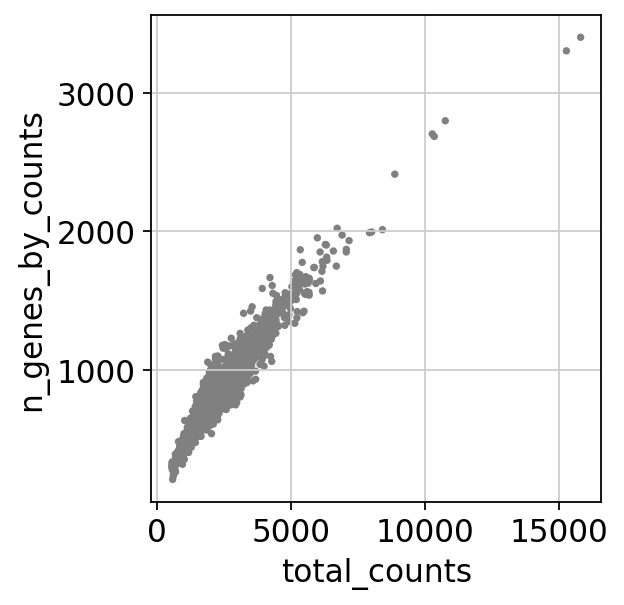

In [12]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

Filter by slicing the AnnData object.

In [13]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

Total-count normalize the data matrix to 10,000 reads per cell, so that counts are comparable among cells

In [14]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


/home/mesqueda/miniconda3/envs/scanpy/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Logarithmize the data:

In [15]:
sc.pp.log1p(adata)

Identify highly-variable genes.

In [16]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


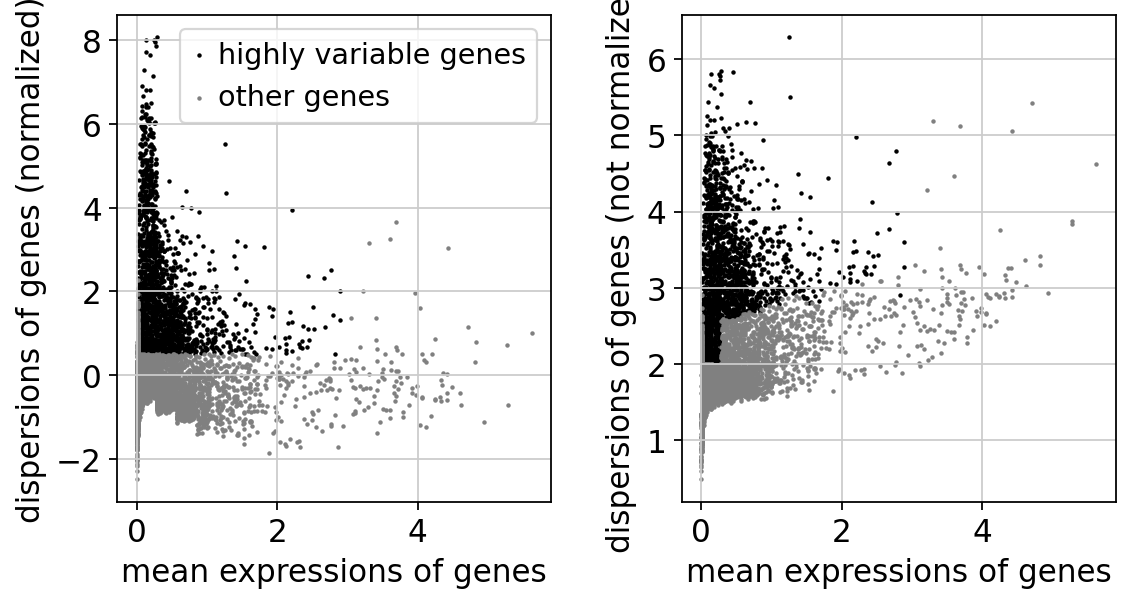

In [17]:
sc.pl.highly_variable_genes(adata)

Set the `.raw` attribute of the AnnData obj to the normalized and logarithmized raw gene expression for later use in differential testing and visualizations of gene expression.

In [18]:
adata.raw = adata

Actually do the filtering

In [19]:
adata = adata[:, adata.var.highly_variable]

Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.

In [20]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:06)


In [21]:
sc.pp.scale(adata, max_value=10)

## Principal component analysis

Reduce the dimensionality of the data by running PCA, which reveals the main axes of variation and denoises the data.

In [22]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


Scatter plot in the PCA coordinates

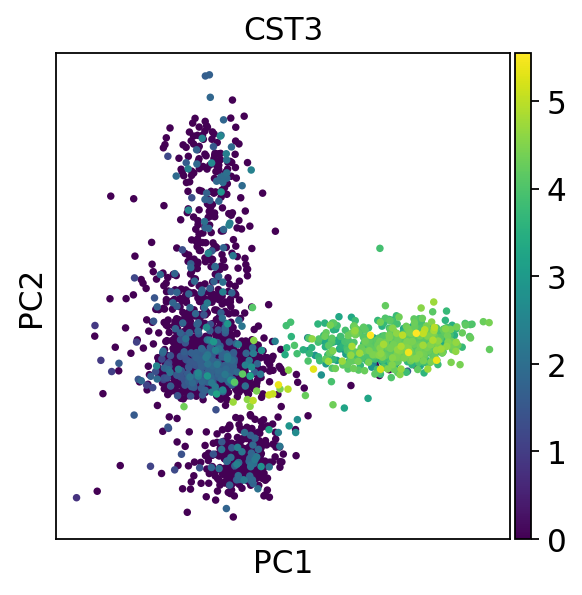

In [23]:
sc.pl.pca(adata, color='CST3')

Inspect the contribution of single PCs to the total variance in the data.

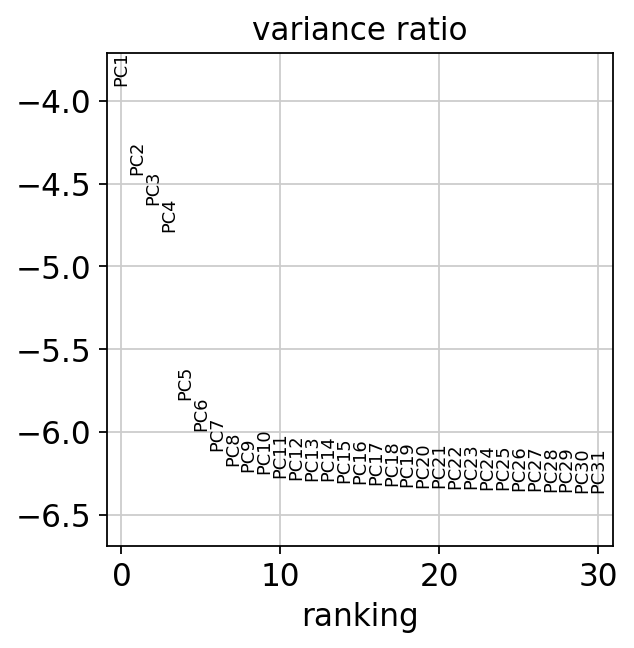

In [24]:
sc.pl.pca_variance_ratio(adata, log=True)

Save the result.

In [25]:
adata.write(results_file)

In [26]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

## Computing the neighborhood graph

Compute the neighborhood graph of cells using the PCA represenation of the data matrix (default values).

In [27]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)


## Embedding the neighborhood graph 

Embed the graph in two dimensions using UMAP

In [30]:
# sc.tl.paga(adata)
# sc.pl.paga(adata, plot=False)                                          # remove `plot=False` if you want to see the coarse-grained graph
# sc.tl.umap(adata, init_pos='paga')

In [31]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)


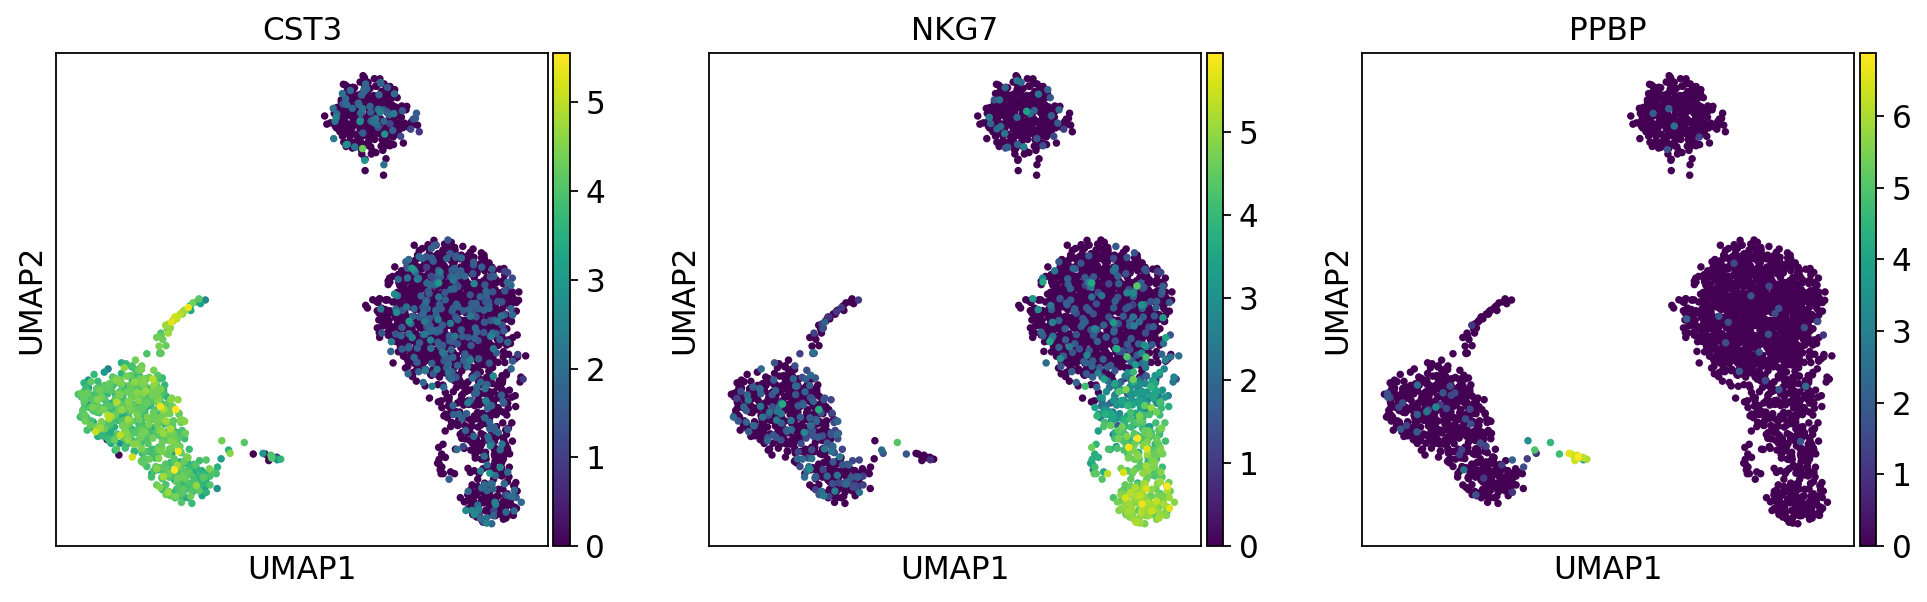

In [32]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'])

The previous plots showed the "raw" (normalized, logarithmized, but uncorrected) gene expression. Can also plot the scaled and corrected gene expression by explicitly stating `use_raw=False`.

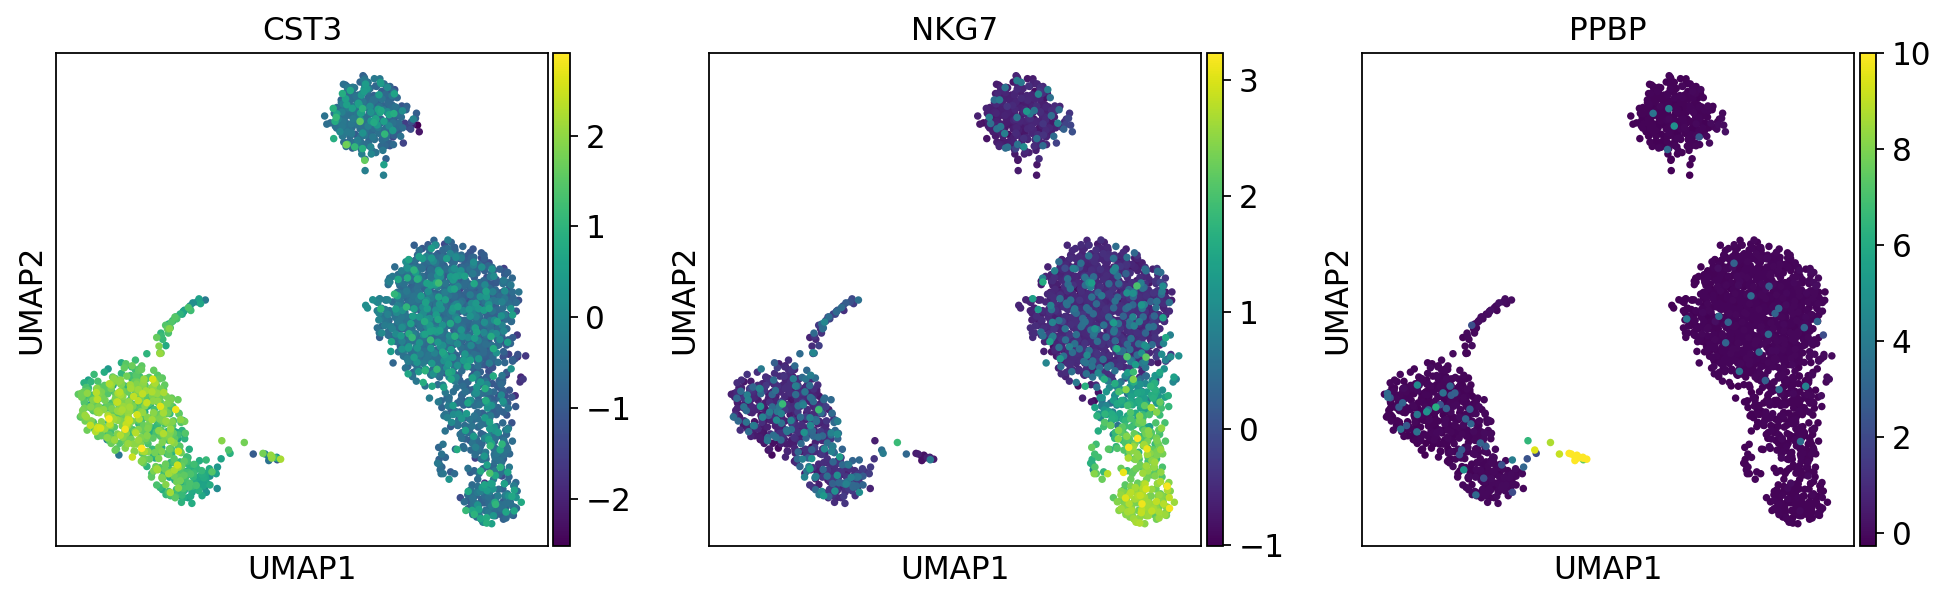

In [33]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'], use_raw=False)

## Clustering the neighborhood graph

Leiden graph-clustering method recommended (community detection based on optimizing modularity). 

In [35]:
sc.tl.leiden(adata)

running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


Plot the clusters

/home/mesqueda/miniconda3/envs/scanpy/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


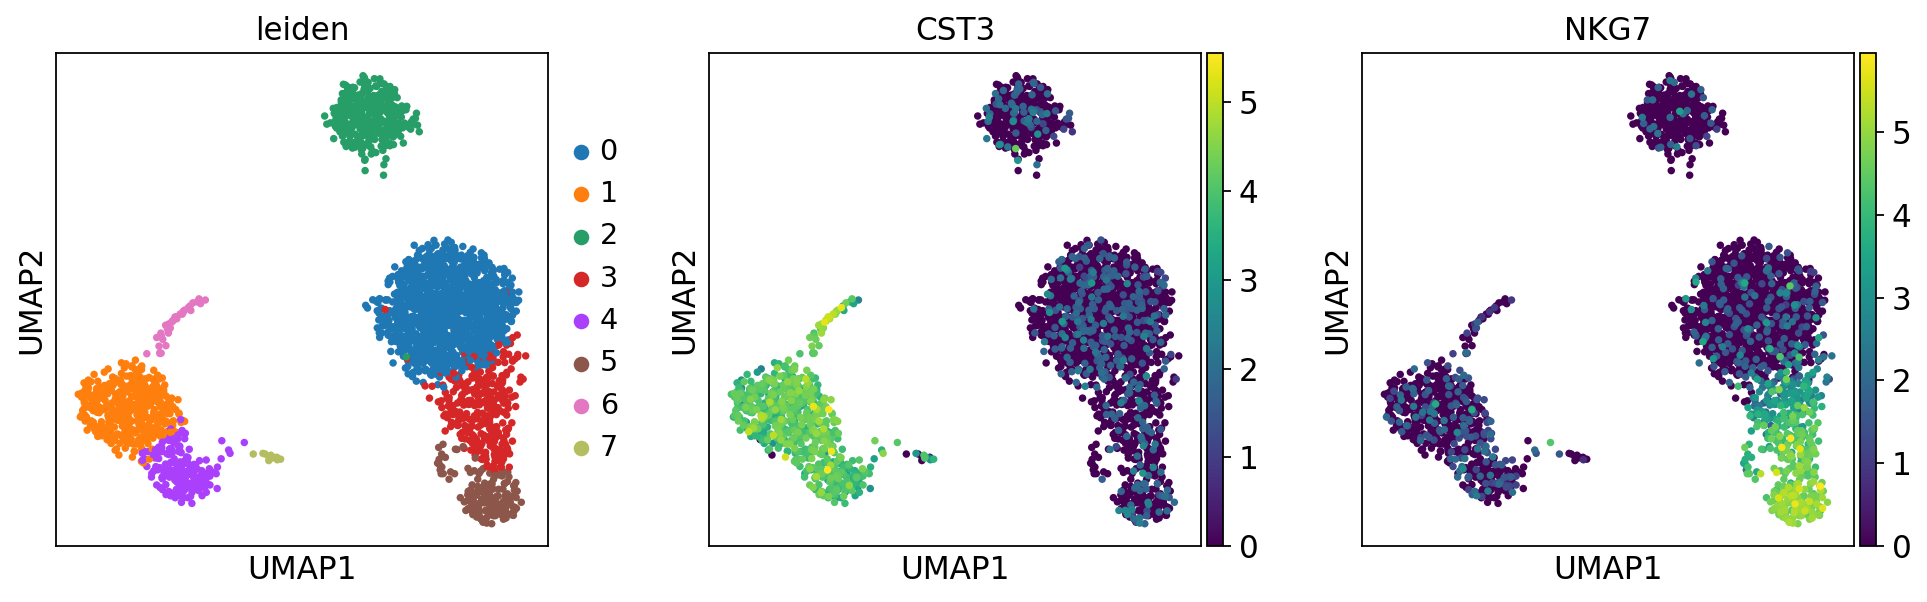

In [36]:
sc.pl.umap(adata, color=['leiden', 'CST3', 'NKG7'])

Save the results

In [37]:
adata.write(results_file)

## Finding marker genes

Compute a ranking for highly differential genes in each cluster

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


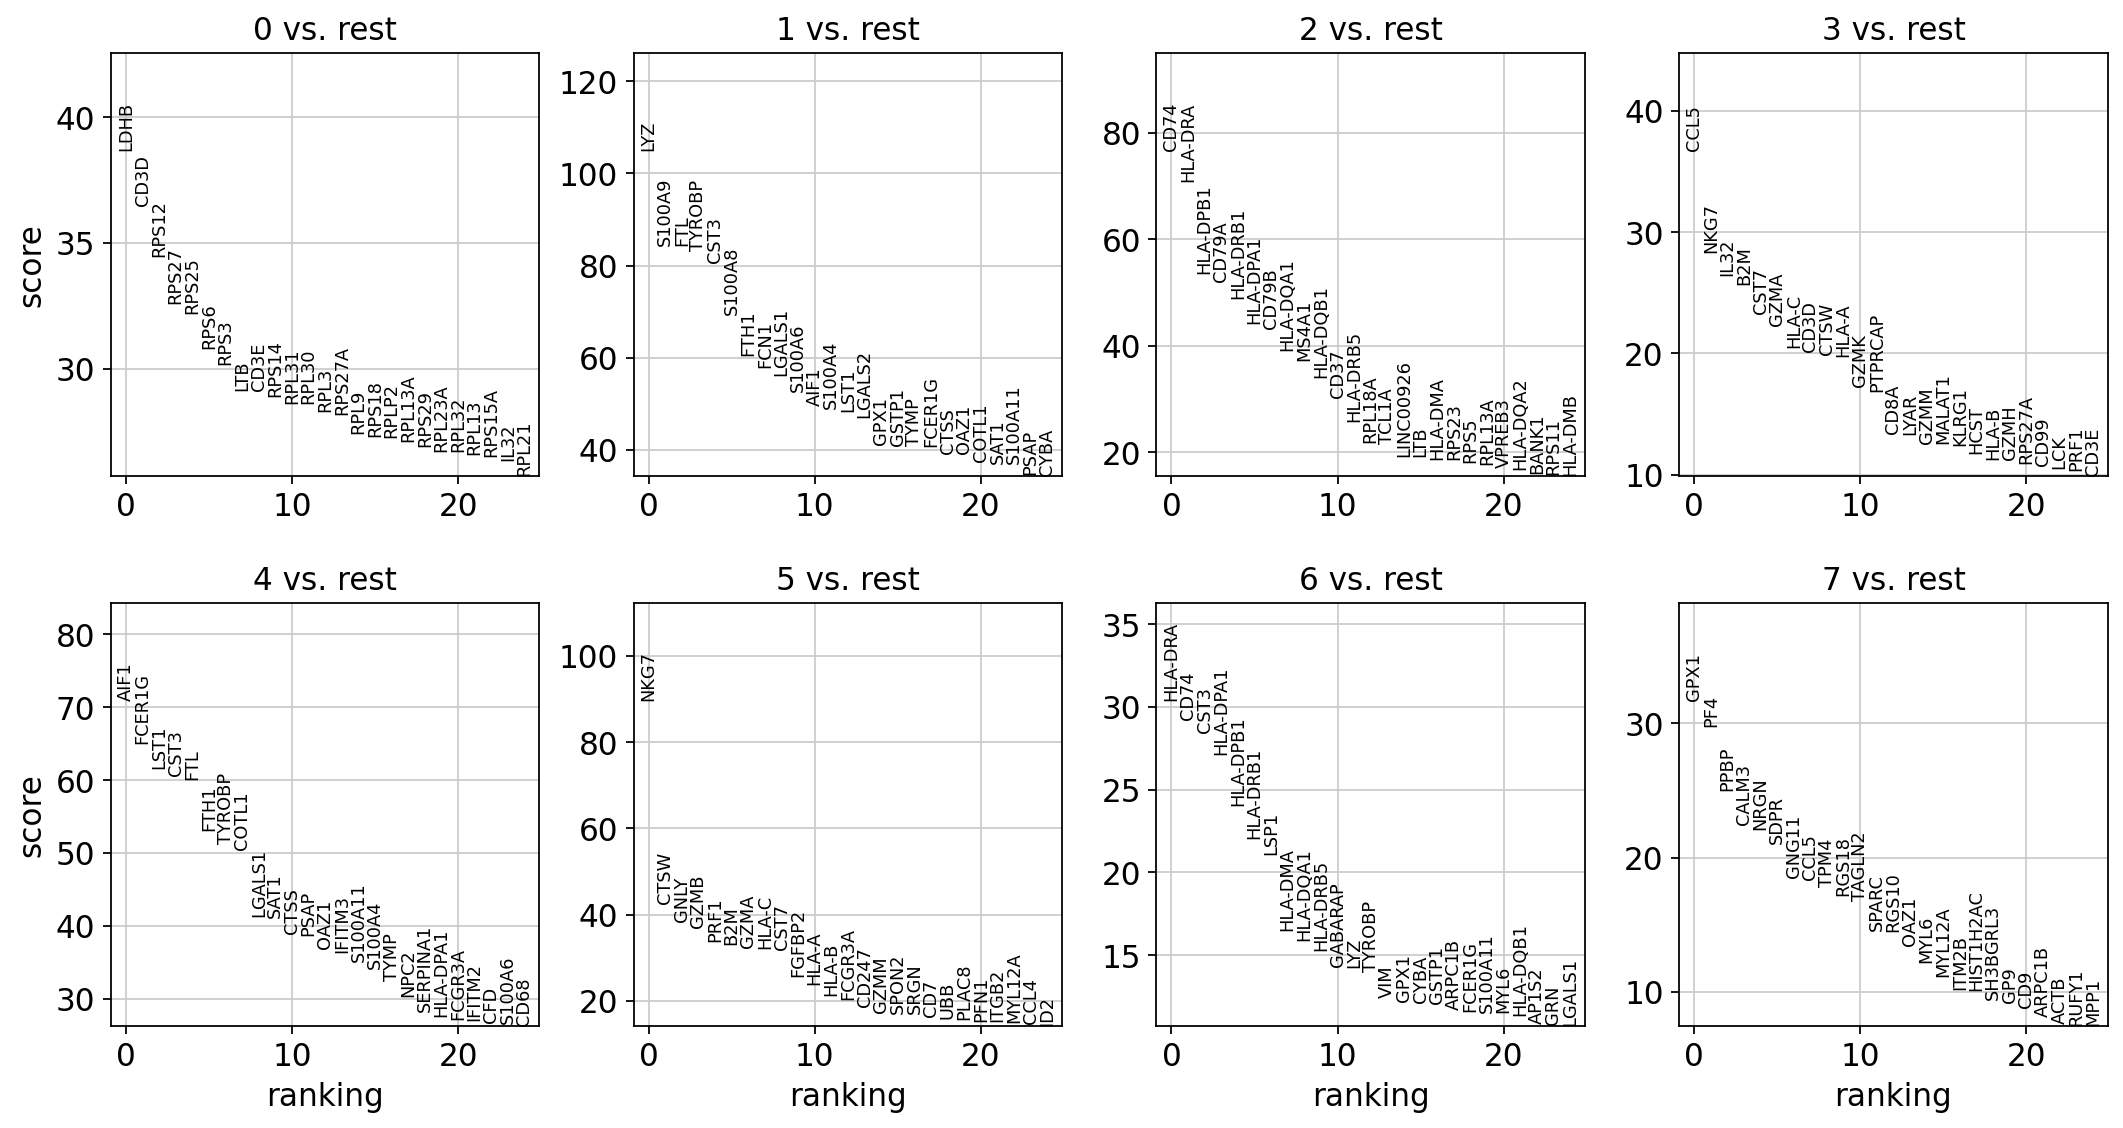

In [38]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [ ]:
sc.settings.verbosity = 2                                         # reduce the verbosity

Results using `'wilcoxon'` test

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)


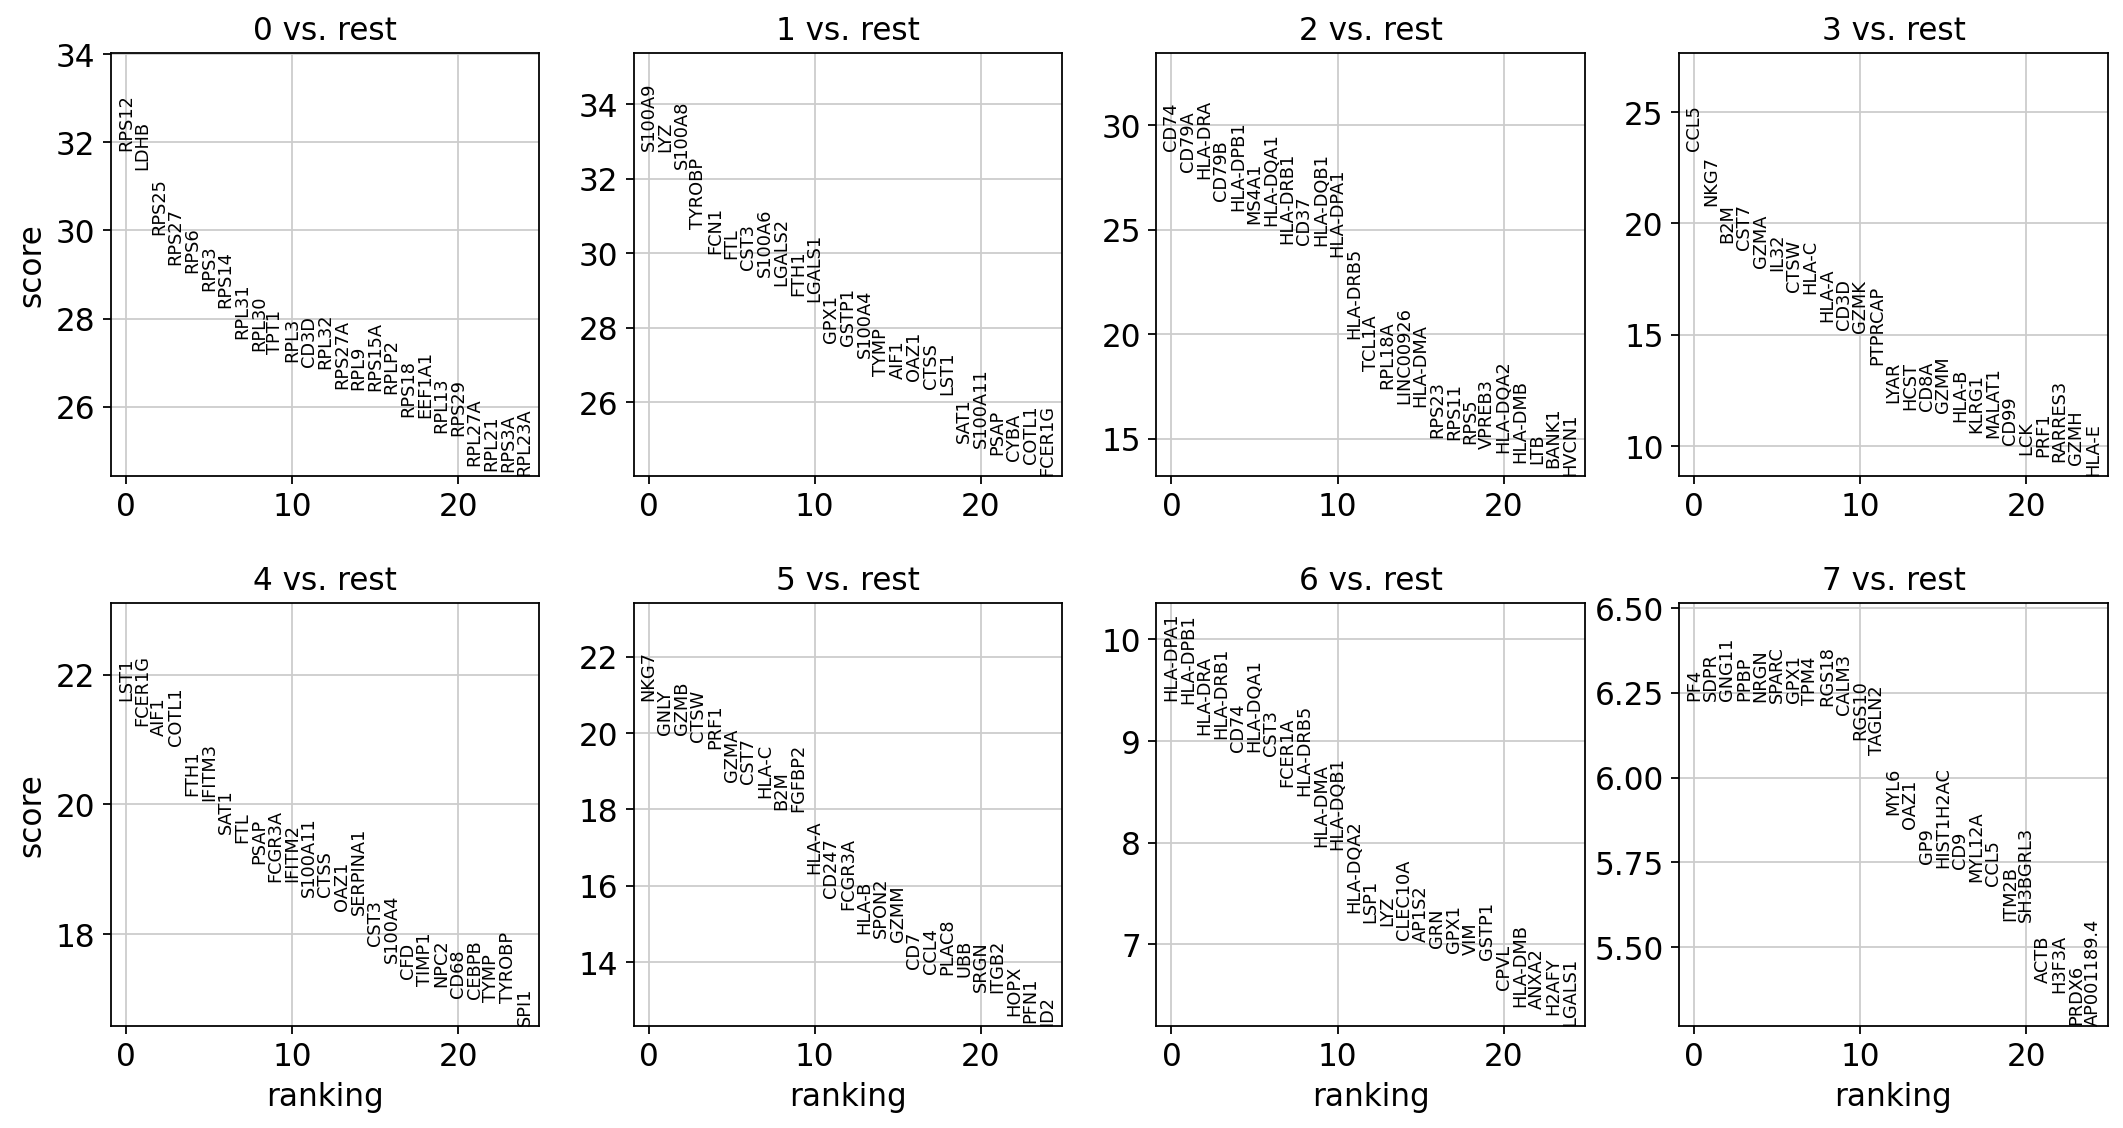

In [39]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [40]:
adata.write(results_file)

As an alternative, rank genes using logistic regression.

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
 (0:00:03)


/home/mesqueda/miniconda3/envs/scanpy/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


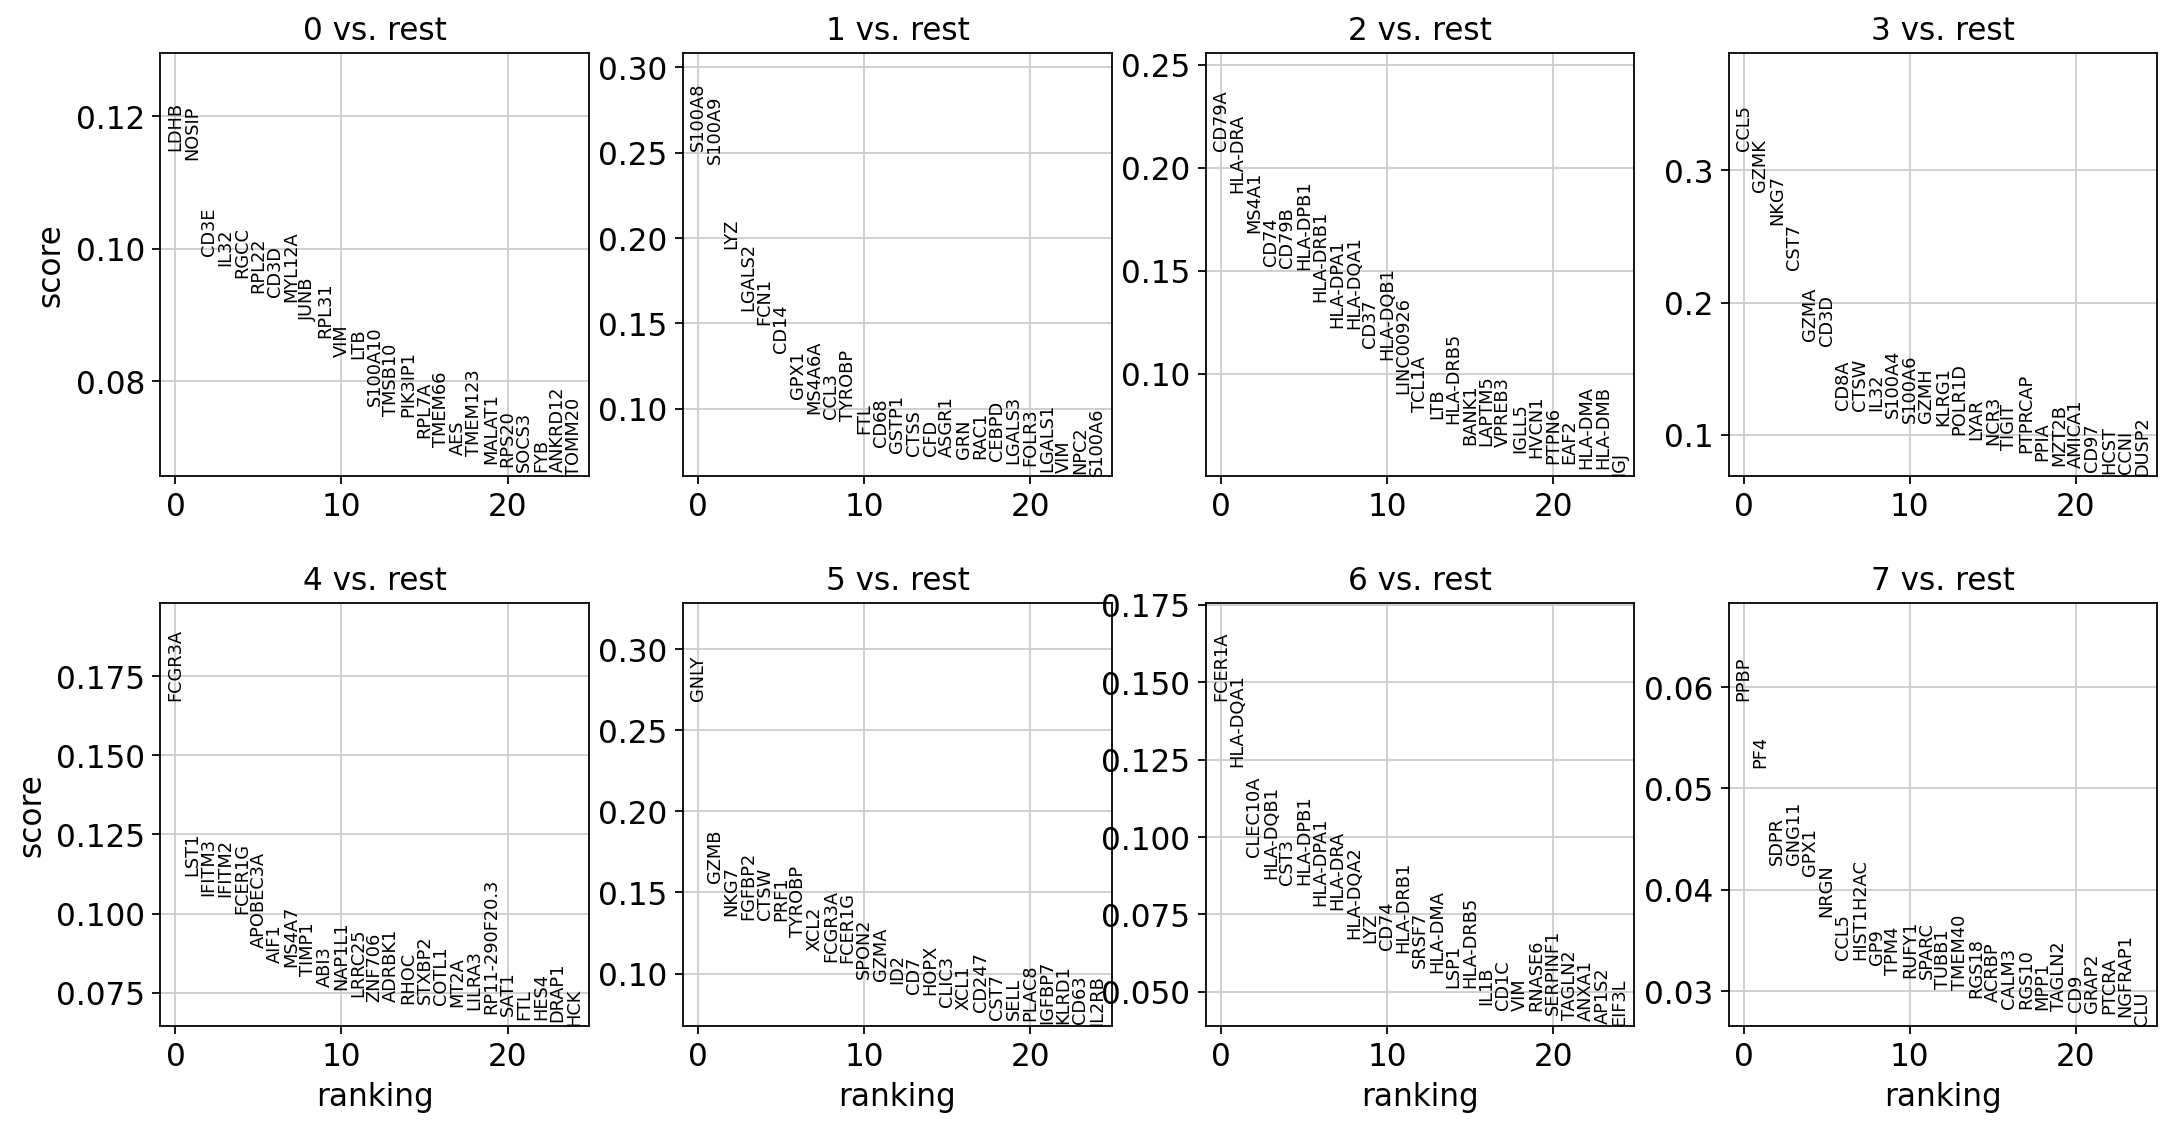

In [41]:
sc.tl.rank_genes_groups(adata, 'leiden', method='logreg')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

Define a list of marker genes for later reference.

In [42]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

Reload the obj that has been saved with the Wilcoxon Rank-Sum test result.

In [43]:
adata = sc.read(results_file)

Show the 10 top ranked genes per cluster 0, 1, ...,7 in a dataframe.

In [44]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

,0,1,2,3,4,5,6,7
0,RPS12,S100A9,CD74,CCL5,LST1,NKG7,HLA-DPA1,PF4
1,LDHB,LYZ,CD79A,NKG7,FCER1G,GNLY,HLA-DPB1,SDPR
2,RPS25,S100A8,HLA-DRA,B2M,AIF1,GZMB,HLA-DRA,GNG11
3,RPS27,TYROBP,CD79B,CST7,COTL1,CTSW,HLA-DRB1,PPBP
4,RPS6,FCN1,HLA-DPB1,GZMA,FTH1,PRF1,CD74,NRGN


Get a table with the scores and groups.

In [45]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

,0_n,0_p,1_n,1_p,2_n,2_p,3_n,3_p,4_n,4_p,5_n,5_p,6_n,6_p,7_n,7_p
0,RPS12,3.636468e-222,S100A9,1.940467e-235,CD74,3.043536e-182,CCL5,8.082693e-120,LST1,1.620366e-103,NKG7,1.203971e-96,HLA-DPA1,5.422417e-21,PF4,4.722886e-10
1,LDHB,3.242464e-216,LYZ,3.649395e-235,CD79A,6.860832e-170,NKG7,4.770586e-96,FCER1G,5.878996e-100,GNLY,1.257170e-88,HLA-DPB1,7.591860e-21,SDPR,4.733899e-10
2,RPS25,1.391861e-196,S100A8,1.662202e-228,HLA-DRA,8.389292e-166,B2M,1.174669e-81,AIF1,2.004511e-98,GZMB,1.429027e-88,HLA-DRA,1.306768e-19,GNG11,4.733899e-10
3,RPS27,9.718451e-188,TYROBP,1.652130e-206,CD79B,1.171444e-153,CST7,6.652244e-79,COTL1,3.853307e-97,CTSW,4.144726e-87,HLA-DRB1,1.865104e-19,PPBP,4.744938e-10
4,RPS6,1.771786e-185,FCN1,1.114817e-197,HLA-DPB1,6.167786e-148,GZMA,1.300917e-72,FTH1,3.651643e-90,PRF1,1.692100e-85,CD74,5.853161e-19,NRGN,4.800511e-10


Compare to a single cluster:

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


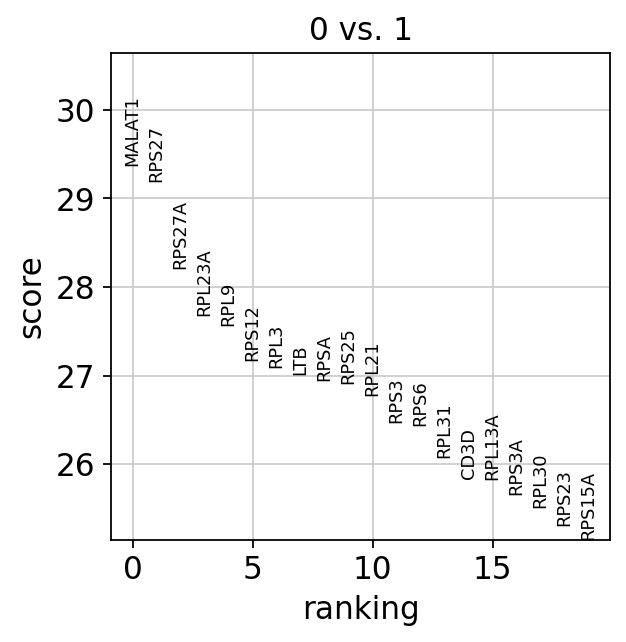

In [46]:
sc.tl.rank_genes_groups(adata, 'leiden', groups=['0'], reference='1', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)

For a more detailed view of a certain group, use `sc.pl.ranke_genes_groups_violin`.

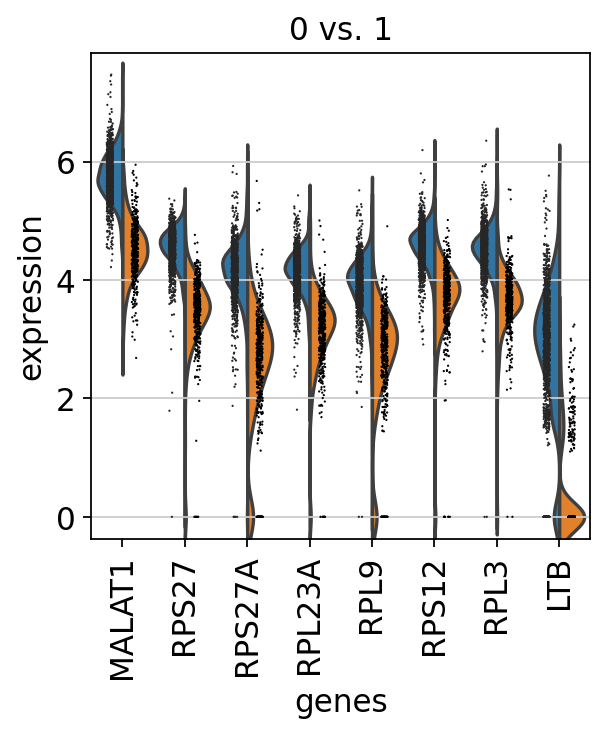

In [47]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

Reload the obj with the computed differential expression (DE via a comparison with the rest of the groups):

In [48]:
adata= sc.read(results_file)

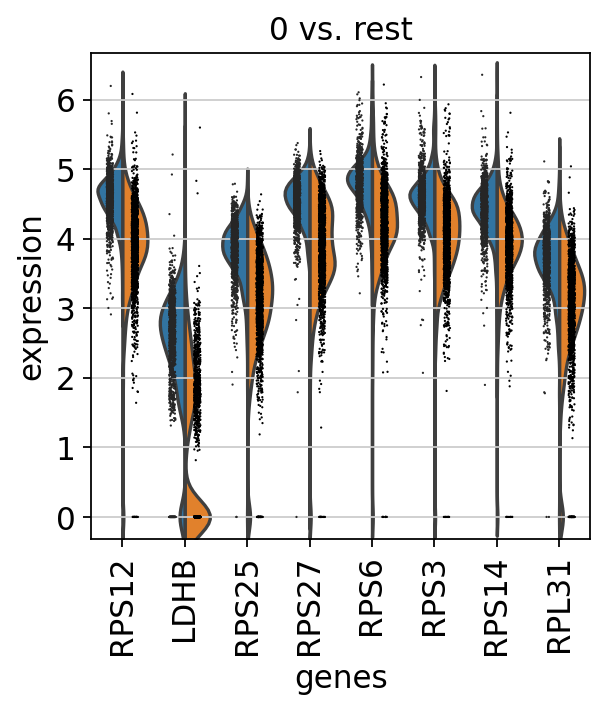

In [49]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

If you want to compare a certain gene across groups, use:

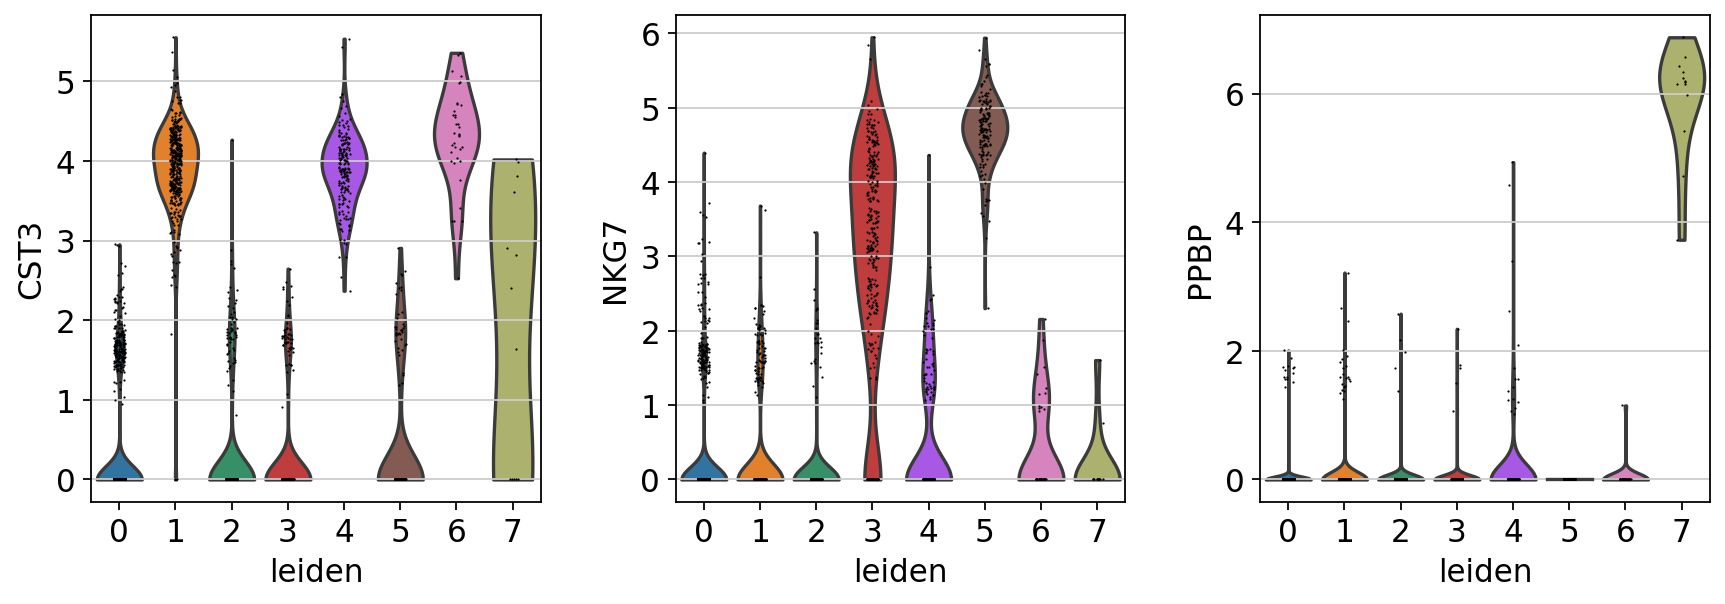

In [50]:
sc.pl.violin(adata, ['CST3', 'NKG7', 'PPBP'], groupby='leiden')

Mark the cell types.

In [51]:
new_cluster_names = [
    'CD4 T', 'CD14 Monocytes',
    'B', 'CD8 T',
    'NK', 'FCGR3A Monocytes',
    'Dendritic', 'Megakaryocytes']
adata.rename_categories('leiden', new_cluster_names)

/home/mesqueda/miniconda3/envs/scanpy/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


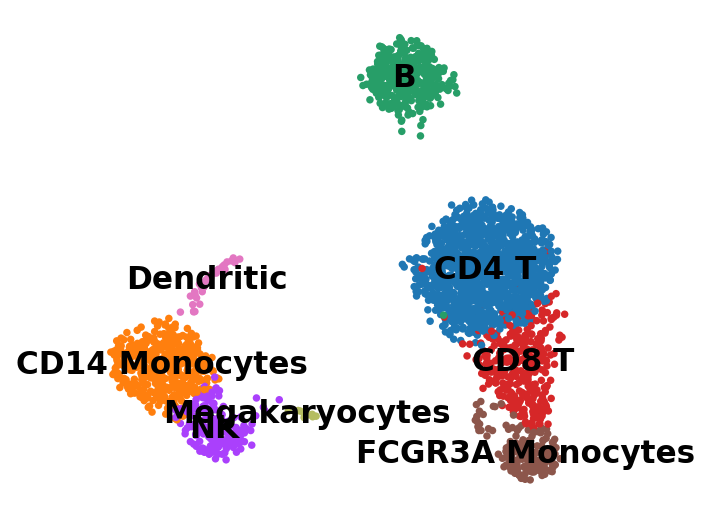

In [52]:
sc.pl.umap(adata, color='leiden', legend_loc='on data', title='', frameon=False, save='.pdf')

Visualize the marker genes.

/home/mesqueda/miniconda3/envs/scanpy/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


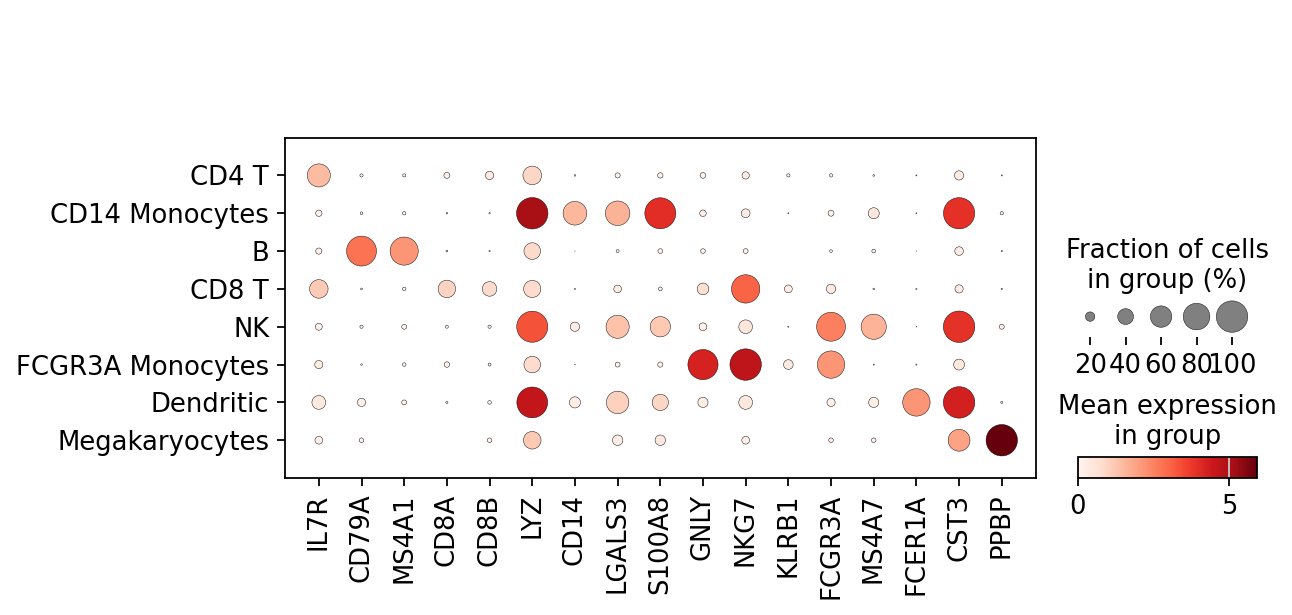

In [54]:
sc.pl.dotplot(adata, marker_genes, groupby='leiden');

Compact violin plot.

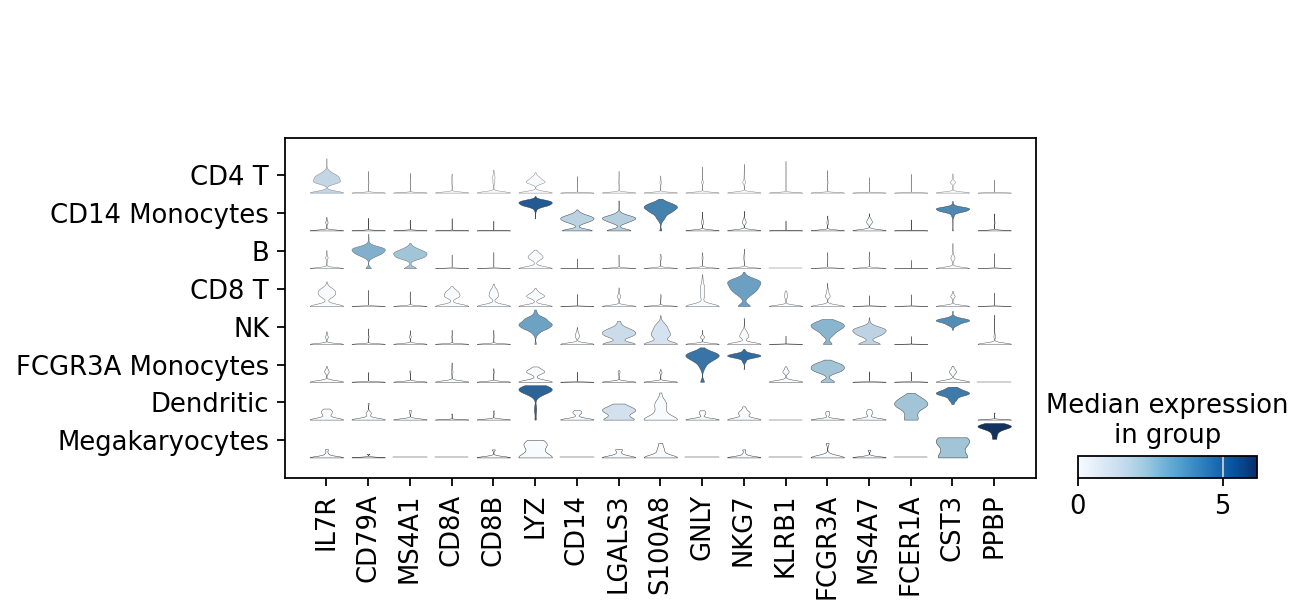

In [55]:
sc.pl.stacked_violin(adata, marker_genes, groupby='leiden', rotation=90);

During the course of this analysis, the AnnData accumalated the following annoations.

In [56]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [57]:
adata.write(results_file, compression='gzip')                   # `compression='gzip'` saves disk space, but slows down writing and subsequent reading

To share this file for visualiztion only, a simple way to reduce the file size is by removing the dense scaled and corrected data matrix. The file still contains the raw data used in the visualizations in `adata.raw`.

In [58]:
adata.raw.to_adata().write('./write/pbmc3k_withoutX.h5ad')